# MIE1624 Assignment 3
### Paul Xie 1002905118


In this assignment, we will use natural language processing to perform sentiment analysis, which will allow us to determine whether a statement or document is "positive" or "negative". The purpose of this assignment is to compute the sentiment of tweets that are recently posted about the 2020 US Presidential Election, and explore **"What can public opinion on Twitter tell us about the US political landscape in 2020."**

Please install the following packages if you have not done so yet.

In [1]:
# %pip install nltk
# %pip install demoji
# %pip install heapq
# %pip install prettytable
# %pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import sklearn
#from scipy import zeros as sci_zeros
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.probability import ConditionalFreqDist, FreqDist
from nltk.tokenize import word_tokenize

import matplotlib.ticker as ticker 
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import demoji
demoji.download_codes();
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import RegexpTokenizer

import heapq
import time 
from prettytable import PrettyTable

... OK (Got response in 0.33 seconds)
Writing emoji data to /Users/paulxie/.demoji/codes.json ...
... OK


I have updated the file `stop_words.txt` so that it contains more useless words such as "rt", which are commonly seen in a tweet but really makes no difference to the sentiment. 

In [3]:
sentiment_analysis = pd.read_csv('sentiment_analysis.csv');
us_election = pd.read_csv('US_Elections_2020.csv', encoding = 'ascii');

stop_words = np.genfromtxt('stop_words.txt', dtype = str, autostrip = True, usecols = 0)
corpus = np.genfromtxt('corpus.txt', dtype = str, replace_space = '_', usecols = (0,1))

In [4]:
sentiment_df = sentiment_analysis.drop('ID', axis =1)
election_df = us_election

### 1. Data cleaning

The two dataframes (`sentiment_df` and `election_df`) are very "noisy", as they contain some punctuations, URLs, HTML character codes and emojis. For the emojis, I decided to use the `demoji` package to decode them into ASCII equivalent. I do not want to remove the emojis completely because, as the saying goes, "sometimes words aren't enough". Those emojis curtainly contain useful information about the sentiment of the tweets (if a tweet contains "❤️", it is very likely to be a positive tweet). I have therefore defined the following functions to help with data cleaning. Note that the function `drop_stop_words` also replace all the double spaces with a single space.

In [5]:
## decode emoji
def decode_emoji(twt):
    emoji_list = demoji.findall(twt)
    for k in emoji_list.keys():
        twt = twt.replace(k, emoji_list[k])
    return twt


## drop punctuations
def drop_punct(twt):
    tw = twt.replace('-',' ').replace('!','').replace('#',' ').replace('.','').replace("'",'').replace('&', ' ').replace('<', ' ').replace('>', ' ').replace('+', ' ').replace(':', '')
    tw = tw.replace('(','').replace(')','').replace('[', '').replace(']', '').replace(',', '').replace('’','').replace('‘', '').replace('"', ' ').replace('?', '').replace('=', '').replace(';','')
    tw = tw.replace('/','').replace('\\', ' ').replace('…', ' ').replace('–', ' ').replace('“', '').replace('”', '').replace('|', '').replace('%', '')
    tw = tw.replace('@','')
    return tw

## remove all URLs
def drop_url(twt):
    segment = twt.split(' ')
    for s in segment: 
        if ('http' in s) or ('.com' in s):
            segment.remove(s)
    sent = ' '.join(segment)
    return sent

## drop all stop words 
def drop_stop_words(twt):
    segment = twt.lower().split(' ')
    s = 0
    while s < len(segment):
        if (segment[s] in stop_words) or (segment[s] == ''):
            #print(seg[s])
            segment.remove(segment[s])
        else:
            s += 1
    sent = ' '.join(segment)
    return sent 

In [6]:
sentiment_df['text'] = sentiment_df['text'].map(lambda x: drop_stop_words(drop_punct(drop_url(decode_emoji(x)))))
election_df['text'] = us_election['text'].map(lambda x: drop_stop_words(drop_punct(drop_url(decode_emoji(x)))))

In [7]:
sentiment_df.loc[26, 'text']

'duncanslater3 great meet supportthewalk team ragc16 event today hertssv sportinherts'

### 2. Exploratory analysis and visualization

Now that those two datasets have been cleaned, as they only contain words that are likely to make an impact of the sentiment. I will do some exploratory analysis. First, I'd like to check the sentiment distribution for both of the political parties, I created two sets of keywords for both the republican party and the democratic party. If a tweet contains words such as "trump2020" or "trumppence", it is almost certain that the tweet comes from a supportor of Republican party. Furthermore, a tweet may contain critism towards the opposing candidate such as "sleepyjoe" and "trumpvirus", we can infer the partisanship of the tweets by looking at those keywords. The two sets of keywords are listed below, if a tweet contains any word listed in `rep_keywords`, we will say that tweet is Republican and viceversa.

In [8]:
rep_keywords = ['trump2020', 'trumppence2020', 'trumppence', 'republican', 'hunterbiden', 'sleepyjoe']
dem_keywords = ['biden2020', 'bidenharris2020', 'bidenharris', 'democrat', 'trumpvirus']

In [9]:
def political_party(twt):
    rep = []
    dem = []
    for kw in rep_keywords:
        rep.append(kw in twt)
    for kw in dem_keywords:
        dem.append(kw in twt)
        
    if any(rep):
        return 'Republican'
    elif any(dem):
        return 'Democratic'
    else:
        return 'Others'

In [10]:
election_df['Partisan'] = election_df['text'].map(lambda x: political_party(x))

In [11]:
election_df.Partisan.value_counts()

Others        2017
Democratic     414
Republican     121
Name: Partisan, dtype: int64

Usin the `value_counts` function on tweets partisanship, we can see that 80% of the tweets about US election is classifed as "Others" according to our criteria. Interestingly, even though the Republican party has one more keyword than the Democratic party, the number of tweets being classified as "Republican" is almost a quarter of the number of tweets being classified as "Democratic". This interesting fact indicates that supportors of the repunlican party is a lot less active on social media compare to the supportors of the democratic party. This reflects another fact that most polls before the election predicted Biden to have a dominant victory, and most celebraties are flatout opposing Trump gave us a feeling that Trump will have no chance at all in this election. However, in reality it was a neck-and-neck battle till the very end. Trump supportors do not voice as much as those who oppose Trump, but they will make sure they go out and vote for him.

/Users/paulxie/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/paulxie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


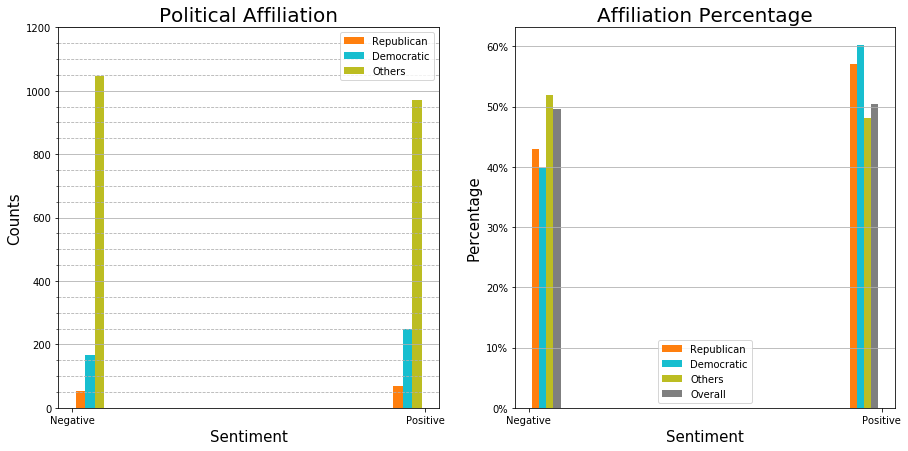

In [12]:
repub_df = election_df[election_df.Partisan == 'Republican']
democ_df = election_df[election_df.Partisan == 'Democratic']
other_df = election_df[election_df.Partisan == 'Others']


fig_1, (ax1, ax2)= plt.subplots(1, 2, figsize = (15, 7))
#note the ax option.
ax1.hist([repub_df.sentiment, democ_df.sentiment, other_df.sentiment], label = ['Republican', 'Democratic', 'Others'], color = ['tab:orange', 'tab:cyan', 'tab:olive']);
ax1.set_xticks([0, 1])
ax1.set_xticklabels( ('Negative', 'Positive') )
ax1.set_yticks(np.linspace(50, 1200, 24), minor = True)
ax1.yaxis.grid(which = 'minor', linestyle = '--')
ax1.yaxis.grid(linestyle = '-')
ax1.legend(loc = 'best')
ax1.set_title('Political Affiliation', fontsize = 20)
ax1.set_xlabel('Sentiment', fontsize = 15)
ax1.set_ylabel('Counts', fontsize = 15)

w1 = np.ones(len(repub_df.sentiment))/len(repub_df.sentiment)
w2 = np.ones(len(democ_df.sentiment))/len(democ_df.sentiment)
w3 = np.ones(len(other_df.sentiment))/len(other_df.sentiment)
w4 = np.ones(len(election_df.sentiment))/len(election_df.sentiment)
ax2.hist([repub_df.sentiment, democ_df.sentiment, other_df.sentiment, election_df.sentiment], 
         weights = [w1, w2, w3, w4], label = ['Republican', 'Democratic', 'Others', 'Overall'], color = ['tab:orange', 'tab:cyan', 'tab:olive', 'tab:grey']);
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax2.set_xticks([0, 1])
ax2.set_xticklabels( ('Negative', 'Positive') )
ax2.set_ylabel('Percentage', fontsize = 15)
ax2.set_title('Affiliation Percentage', fontsize = 20)
ax2.yaxis.grid()
ax2.set_xlabel('Sentiment', fontsize = 15)
ax2.legend(loc = 'best');
fig_1.show()

From the plot above, I have also plotted the percentage of sentiment for each political party. We can see from the second plot that there are about 50% positive tweets and 50% negative tweets overall; there are more negative apolitical tweets than positive apolitical tweets; there are a lot more positive tweets than the negative ones for both the Republican and Democratc party. We may infer from this plot that supportors of both the Republican party and Democratic party were pretty positive about the chance of their candidate being elected, while those who are apolitical were more likely to feel bad about the 2020 electorial class. 

Next, I will try to visualize some aspect of the generic tweets in `sentiment_analysis.csv` and the 2020 US election tweets. First I decided to do a word cloud for the generic tweets in `sentiment_analysis.csv`.

In [13]:
posit_str = ' '.join(txt for txt in sentiment_df[sentiment_df['label'] == 1].text)
negat_str = ' '.join(txt for txt in sentiment_df[sentiment_df['label'] == 0].text)

In [14]:
wc_pos = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick', width = 500, height = 500)
wc_neg = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick', width = 500, height = 500)

wc_pos.generate(posit_str)
wc_neg.generate(negat_str)

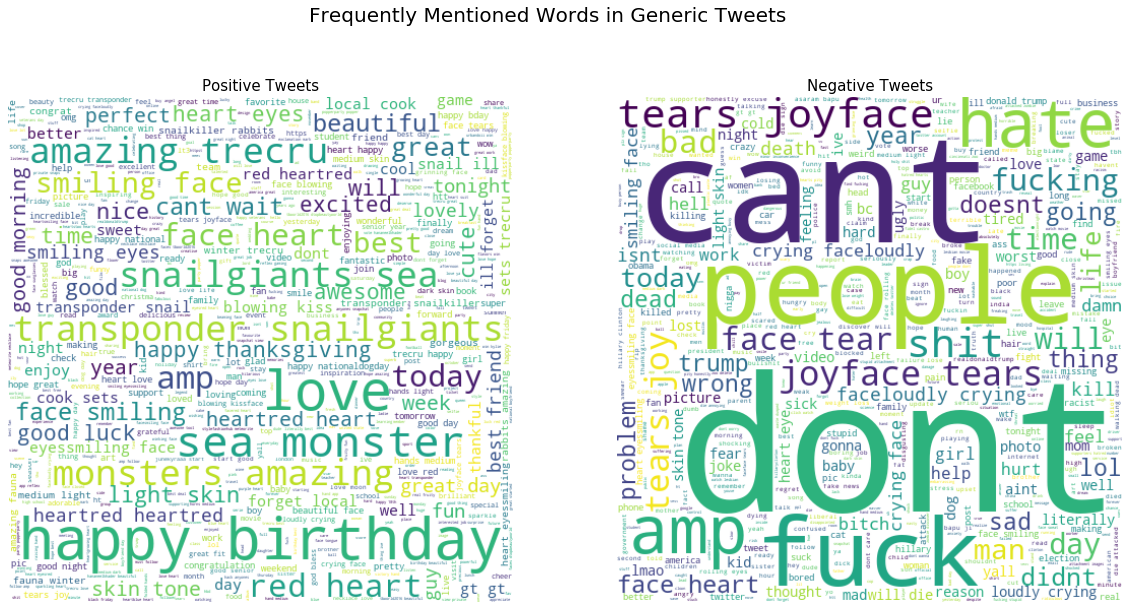

In [15]:
fig_2, (ax1, ax2)= plt.subplots(1, 2, figsize=[20,10])
ax1.imshow(wc_pos, interpolation="bilinear")
ax1.axis("off")
ax1.set_title('Positive Tweets', fontsize = 15)
ax2.imshow(wc_neg, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Negative Tweets', fontsize = 15)
fig_2.suptitle('Frequently Mentioned Words in Generic Tweets', fontsize = 20)
plt.show()

I computed the word clouds for positive tweets and negative tweets, each of the word cloud contains a maximum of 1000 words. As we can see from the two word clouds, words such as "happy", "love", "amazing" etc. are some of the most used words in positive tweets. On the other hand, some bad words ("f\*\*\*", "hate", "sh\*\*") were used a lot in the negative tweets. This is basically common sense because positive tweets are usually birthday wishes, holiday wishes and compliments, while negative tweets usually contain some swear words (at least that's what I usually do). 

Next, I will do some visualization of the US election tweets. I want to see whether the original length of the tweets will make a difference in predicting the sentiment, since when makig compliments and birthday wishes, people often tend to write a relativly long paragraph. When expression negative opinions, people sometimes do not have the patient to type in a lot of words. So I created another column in the `us_election` dataframe called `length`. This is the original length of the content after dropping all the URLs. It does not make any sense to include the URLs because some URLs are simply too long than the others. 

Further, I decided to plot the distribution of negative reasons to check what are the most common negative reasons for the US election tweets. Lastly, I made word clouds for positive and negative tweets in the US election dataset.

In [16]:
## Exploratory analysis for US election tweets 

us_election['length'] = us_election['text'].map(lambda x: len(drop_url(x))) ## length of original tweet exclude url

us_election_pos = us_election[us_election['sentiment'] == 1]
us_election_neg = us_election[us_election['sentiment'] == 0]

In [17]:
elec_posit_str = ' '.join(txt for txt in us_election_pos.text)
elec_negat_str = ' '.join(txt for txt in us_election_neg.text)

wc_pos_elec = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='firebrick', width = 500, height = 500)
wc_neg_elec = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='firebrick', width = 500, height = 500)

wc_pos_elec.generate(elec_posit_str)
wc_neg_elec.generate(elec_negat_str)

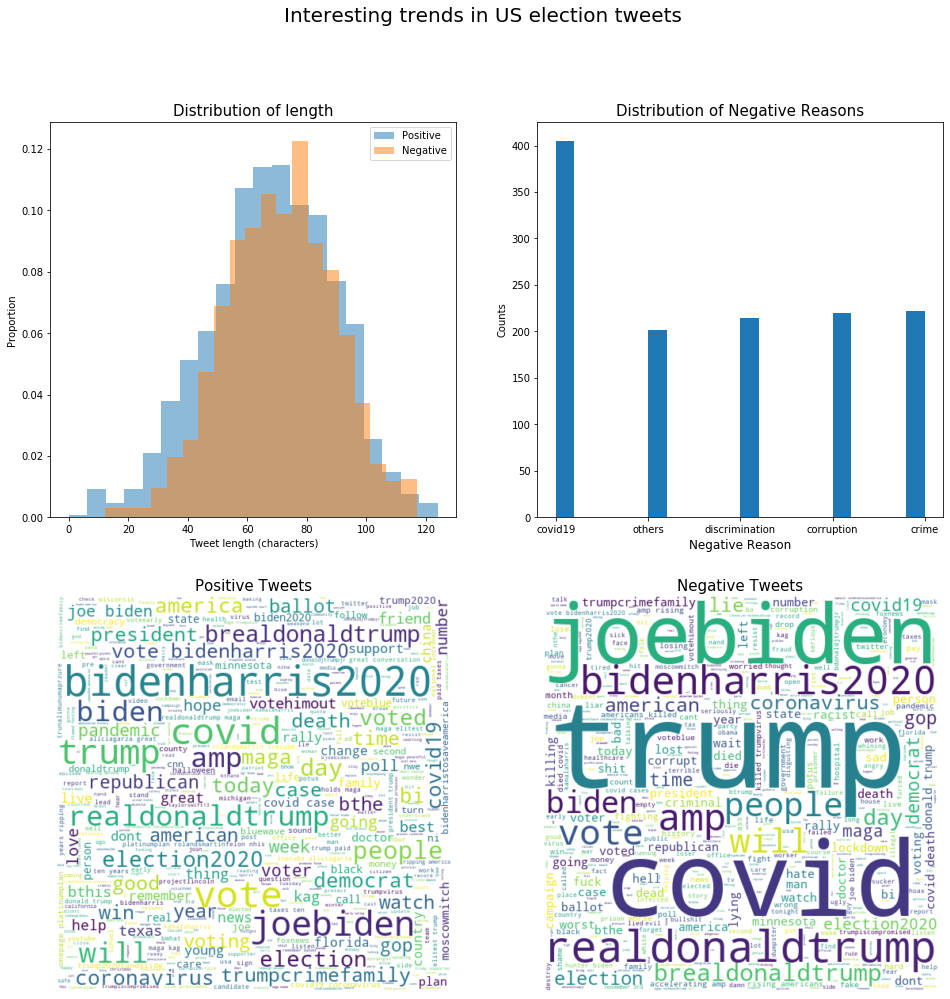

In [18]:


fig_3, ax = plt.subplots(2,2, figsize = [16, 16])

ax[0][0].hist(us_election_pos['length'], weights = np.ones(len(us_election_pos['length']))/ len(us_election_pos['length']), bins = 20, label = 'Positive', alpha = 0.5)
ax[0][0].hist(us_election_neg['length'], weights = np.ones(len(us_election_neg['length']))/ len(us_election_neg['length']), bins = 20, label = 'Negative', alpha = 0.5)
ax[0][0].set_xlabel('Tweet length (characters)')
ax[0][0].set_ylabel('Proportion')
ax[0][0].set_title('Distribution of length', fontsize = 15)
ax[0][0].legend()

ax[0][1].hist(us_election_neg['negative_reason'], bins = 20, label = 'Negative')
ax[0][1].set_xlabel('Negative Reason', fontsize = 12)
ax[0][1].set_ylabel('Counts')
ax[0][1].set_title('Distribution of Negative Reasons', fontsize = 15);

ax[1][0].imshow(wc_pos_elec, interpolation="bilinear")
ax[1][0].axis("off")
ax[1][0].set_title('Positive Tweets', fontsize = 15)
ax[1][1].imshow(wc_neg_elec, interpolation='bilinear')
ax[1][1].axis('off')
ax[1][1].set_title('Negative Tweets', fontsize = 15)
fig_3.suptitle('Interesting trends in US election tweets', fontsize = 20)
plt.show()

From the top-left figure, positive and negative tweets seem to have the same mean length, while the length of positive tweets is more spread out. From the top-right figure, we can tell that the most common reason for nagative reasons in the US election tweets is COVID-19, while the other four reasons were mentioned approximately the same number of times. From the word clouds, the single most used word for negative tweets is "trump", followed by "realdonaldtrump". This reflects how disliked Donald Trump is among American netizons. No supprise that COVID-19 remains the most concerned issue in America right now. From the figures above, we may infer that Trump is very disliked because of the way he handels the COVID19 pandemic.

### 3. Model preparation and implementation 
#### 3.1 Bag of words (word frequency) features

We need to define a feature space so we can apply classification algorithms. Here, I will use two different types of feature spaces: bag of words (word frequency) and TF-IDF. I will then apply a couple of classification algorithms to predict the sentiments for each feature space. First, I will prepare the model using bag of words.

In [19]:
## Model preparation using bag of words 

generic_words = ' '.join(twt for twt in sentiment_df['text'])
fdist = FreqDist(word for word in word_tokenize(generic_words))
print('Length of frequency dictionary is {}'.format(len(fdist)))

Length of frequency dictionary is 516809


The length of frequency dictionary list is over 50K, which basically means there were more than 500K useful words in total that were used in the generic tweet dataframe. If we implement a model with this large number of features, it is doomed to overfit. Plus, it will take very long time to train our model or make predictions. Therefore, I used the `heapq` package to select the most used 300 words so that our model will have 300 features.

In [20]:
most_freq = heapq.nlargest(300, fdist, key=fdist.get)  ## most frequently mentioned words, will be our feature space 

In [21]:
vectorizer = CountVectorizer(vocabulary=most_freq)
X = vectorizer.fit_transform(sentiment_df.text)

In [22]:
feat_space =X.toarray()

In [23]:
bow_df = pd.DataFrame(feat_space, columns = most_freq)
bow_df['y'] = sentiment_df.label

In [24]:
bow_df

,love,happy,heart,face,great,good,best,amazing,birthday,day,...,fucked,quote,moon,travel,app,playing,beauty,celebrate,exciting,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
550389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Independent variable is set to be word frequency and target variable is then sentiment of each tweet. From here, split the dataset in to training and testing set, with 30% of the samples goes to testing set. Then I will prepare the US election dataframe using the same features.

In [25]:
ind_var = bow_df.drop('y', axis = 1)
tar_var = bow_df['y']

train_x_bow, test_x_bow, train_y_bow, test_y_bow = train_test_split(ind_var, tar_var, test_size = 0.3)

In [26]:
elec_vectorizer = CountVectorizer(vocabulary=most_freq)
X_elec = elec_vectorizer.fit_transform(election_df.text)

elec_feat_space =X_elec.toarray()
elec_bow_df = pd.DataFrame(elec_feat_space, columns = most_freq)
elec_bow_df['y'] = election_df.sentiment
elec_bow_df

,love,happy,heart,face,great,good,best,amazing,birthday,day,...,fucked,quote,moon,travel,app,playing,beauty,celebrate,exciting,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With the two datasets well prepared for further analysis, I will first implement the logistic regression model on the bag of words feature space. First, I will do a simple quick fit to check the time needed to train the model, training accuracy and testing acuracy. From a glance, the logistic regression model got close to 90% training and testing accuracy. This is good because we are not overfitting or underfitting the data. Due to the fact that it took relatively short time to train the model, I decided to perform 10-fold cross validation to check if the testing accuracy is consistent across the folds.

In [27]:
## implement logistic regression to BOW features 

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

In [28]:
## all features are already on the same scale, no need to use scaler 

# train and fit the model 
Logi_model = LogisticRegression()
start_time = time.time()
Logi_model.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to train the logistic regression model.'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_bow, Logi_model.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, Logi_model.predict(test_x_bow))
print("The logistic regression model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 18.800501108169556 to train the logistic regression model.
The logistic regression model got a training accuracy of 0.878;
it got a testing accuracy of 0.877


In [29]:
## cross-validation

def run_kfold(model, X, Y, n_folds = 10):
    
    
    kf = KFold(n_splits= n_folds) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

    
run_kfold(Logi_model, train_x_bow, train_y_bow)

Fold 1 accuracy: 0.4366835431316788
Fold 2 accuracy: 0.44032094789612
Fold 3 accuracy: 0.4450045299685732
Fold 4 accuracy: 0.4365078333760031
Fold 5 accuracy: 0.4479241623252205
Fold 6 accuracy: 0.44450007310464934
Fold 7 accuracy: 0.43589290418510107
Fold 8 accuracy: 0.42144923584290583
Fold 9 accuracy: 0.4514405882728718
Fold 10 accuracy: 0.44065752686738324
Mean r2: 0.44003813449705065
Standard Deviation: 0.007897400801581085


In the cross validation, I decided to use `r2_score` as a metric of accuracy. From the result of the cross validation, we can tell that the accuracy is very consistant across all ten folds, with standard deviation smaller than 0.7%. I will then use grid search to find the best logistic regression model. The terms I will variate is the penalization strength "C" and penalization "penalty". 

In [30]:
# gird search for logistic regression

reg_gridsearch = LogisticRegression()
#Parameters to test
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]# Constant that multiplies the L1 term. Defaults to 1.0.
             } #

# Compare parameters by score of model 
acc_scorer_logi = make_scorer(r2_score)

# Run the grid search
start_time = time.time()
grid_obj_logi = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_logi)
grid_obj_logi = grid_obj_logi.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to complete grid search for logistic regression model'.format(end_time - start_time))

reg_gridsearch = grid_obj_logi.best_estimator_  #Select best parameter combination

train_ACC = accuracy_score(train_y_bow, reg_gridsearch.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, reg_gridsearch.predict(test_x_bow))
print("The best logistic regression model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 450.49199414253235 to complete grid search for logistic regression model
The best logistic regression model got a training accuracy of 0.878;
it got a testing accuracy of 0.877


I then applied the tuned logistic regression model on the US election dataset, it performed well. Our best logistic regression model predicted the correct sentiment for about 60% of the tweets in the US election dataset. 

In [31]:
tuned_logi = reg_gridsearch
acc = accuracy_score(elec_bow_df['y'].values, tuned_logi.predict(elec_bow_df.drop('y', axis = 1)))
print('Best performing logistic regression model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing logistic regression model got accuracy score 0.592 on US election tweets


Next, I will apply linear support vector machine model on the BOW feature space. I chose to use linear support vector classification instead of regular SVC because we have a huge sample size, it is stated on their website `scikit-learn.org` that "for large datasets, consider using LinearSVC". The main difference between `LinearSVC` and `SVC` is that the former uses `kernal = 'linear'`. This, of course, saves a lot of computational time for us, but the downside is that it might produce miserable results if the dataset is not linearly separable. Fortunately, we have used (and will use) other models to train this dataset, so we can compare the training/testing errors with other algorithms to check if the linear SVC is a good fit in this case. 

In [32]:
## Applying Support vector machine algorithm on bag of words features 

from sklearn import svm

svm_model = svm.LinearSVC()
start_time = time.time()
svm_model.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to train linear SVM model'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_bow, svm_model.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, svm_model.predict(test_x_bow))
print("The SVM model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 43.20515298843384 to train linear SVM model
The SVM model got a training accuracy of 0.877;
it got a testing accuracy of 0.877


But still, the linear SVC takes way longer time o train compare to the logistic regression, I will not perform cross validation since that is computationally too expensive. Instead, I will go ahead using grid search to find the best performing hyperparameters. 

In [33]:
# grid search for SVM 

svm_gridsearch = svm.LinearSVC()
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0], 'penalty':['l1', 'l2'],
             'fit_intercept':[True, False]}

acc_scorer_svm = make_scorer(r2_score)

start_time = time.time()
grid_obj_svm = GridSearchCV(svm_gridsearch, parameters, scoring=acc_scorer_svm)
grid_obj_svm = grid_obj_svm.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to complete grid search for linear SVM model'.format(end_time - start_time))

svm_gridsearch = grid_obj_svm.best_estimator_ 

train_ACC = accuracy_score(train_y_bow, svm_gridsearch.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, svm_gridsearch.predict(test_x_bow))
print("The best SVM model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 1674.6553242206573 to complete grid search for linear SVM model
The best SVM model got a training accuracy of 0.877;
it got a testing accuracy of 0.877


Then, I will apply the best linear SVC model on the US election dataset and the tuned model predicted correct sentiment in about 60% of the tweets.

In [34]:
tuned_svm = svm_gridsearch
acc = accuracy_score(elec_bow_df['y'].values, tuned_svm.predict(elec_bow_df.drop('y', axis = 1)))
print('Best performing linear SVM model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing linear SVM model got accuracy score 0.581 on US election tweets


Lastly, I applied naive Bayes model on the BOW feature space. Here, I deiced to use the multinomial naive bayes because our feature space is a perfect multinomial distribution, with 300 binomial distributed variables. It is incredibly fast to train the multinomial NB model, and the testing accuracy is over 80%.

In [35]:
## applying multinomial naive Bayes model

nb_model = MultinomialNB()
start_time = time.time()
nb_model.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to train multinomial naive bayes model'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_bow, nb_model.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, nb_model.predict(test_x_bow))
print("The naive bayes model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 0.38560009002685547 to train multinomial naive bayes model
The naive bayes model got a training accuracy of 0.828;
it got a testing accuracy of 0.827


In [36]:
## grid search for multinomial naive bayes 

nb_gridsearch = MultinomialNB()
parameters = {'alpha':[0.0, 1.0, 3.0, 5.0], 'fit_prior':[True, False]}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(nb_gridsearch, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_bow, train_y_bow)
end_time = time.time()
print('It took time {} to complete grid search for NB model'.format(end_time - start_time))

nb_gridsearch = grid_obj.best_estimator_ 

train_ACC = accuracy_score(train_y_bow, nb_gridsearch.predict(train_x_bow))
test_ACC = accuracy_score(test_y_bow, nb_gridsearch.predict(test_x_bow))
print("The best naive bayes model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 40.99328303337097 to complete grid search for NB model
The best naive bayes model got a training accuracy of 0.86;
it got a testing accuracy of 0.86


In [37]:
acc = accuracy_score(elec_bow_df['y'].values, nb_gridsearch.predict(elec_bow_df.drop('y', axis = 1)))
print('Best performing NB model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing NB model got accuracy score 0.57 on US election tweets


#### 3.2 TF-IDF features

Until now, we have only applied models on the BOW (word frequency) feature space, and there might be some better ways to input the feature space using other techniques. In this section I will re-prepare the feature space using TF-IDF method.

In [38]:
## now prepare feature space using TF-IDF

vectorizer2 = TfidfVectorizer(vocabulary=most_freq)
vectors2 = vectorizer2.fit_transform(sentiment_df.text)

dense = vectors2.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=most_freq)

In [39]:
tfidf_df['y'] = sentiment_df.label
tfidf_df.head()

,love,happy,heart,face,great,good,best,amazing,birthday,day,...,fucked,quote,moon,travel,app,playing,beauty,celebrate,exciting,y
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.531971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [40]:
ind_var_2 = tfidf_df.drop('y', axis = 1)
tar_var_2 = tfidf_df['y']

train_x_tfidf, test_x_tfidf, train_y_tfidf, test_y_tfidf = train_test_split(ind_var_2, tar_var_2, test_size = 0.3)

The features are still the same as the previous case, we use the most used 300 words as our feature space, but the values for each feature is different now. Still, the target variable is the sentiment of each tweet, which is a binary variable. 

In [41]:
## prepare US election dataset using TF-IDF

vectorizer2_us = TfidfVectorizer(vocabulary=most_freq)
vector2_us = vectorizer2_us.fit_transform(election_df.text)

dense_us = vector2_us.todense()
denselist_us = dense_us.tolist()
tfidf_df_us = pd.DataFrame(denselist_us, columns = most_freq)
tfidf_df_us['y'] = election_df['sentiment']
tfidf_df_us.head()

,love,happy,heart,face,great,good,best,amazing,birthday,day,...,fucked,quote,moon,travel,app,playing,beauty,celebrate,exciting,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


As before, I will apply a few different models on this new feature space. the first one is logistic regression. 

In [42]:
## apply logistic regression model

tfidf_logi = LogisticRegression()
start_time = time.time()
tfidf_logi.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to train the logistic regression model.'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_tfidf, tfidf_logi.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, tfidf_logi.predict(test_x_tfidf))
print("The logistic regression model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 18.106323957443237 to train the logistic regression model.
The logistic regression model got a training accuracy of 0.877;
it got a testing accuracy of 0.878


In [43]:
# gird search for logistic regression

reg_gridsearch_tfidf = LogisticRegression()
#Parameters to test
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]# Constant that multiplies the L1 term. Defaults to 1.0.
             } #

# Compare parameters by score of model 
acc_scorer_logi = make_scorer(accuracy_score)

# Run the grid search
start_time = time.time()
grid_obj_logi = GridSearchCV(reg_gridsearch_tfidf, parameters, scoring=acc_scorer_logi)
grid_obj_logi = grid_obj_logi.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to complete grid search for logistic regression model'.format(end_time - start_time))

reg_gridsearch_tfidf = grid_obj_logi.best_estimator_  #Select best parameter combination

train_ACC = accuracy_score(train_y_tfidf, reg_gridsearch_tfidf.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, reg_gridsearch_tfidf.predict(test_x_tfidf))
print("The best logistic regression model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 449.4345369338989 to complete grid search for logistic regression model
The best logistic regression model got a training accuracy of 0.877;
it got a testing accuracy of 0.878


Using grid search to find the best performing logistic regression model, then apply the best model on the US election dataset.

In [44]:
acc = accuracy_score(tfidf_df_us['y'], reg_gridsearch_tfidf.predict(tfidf_df_us.drop('y', axis = 1)))
print('Best performing logistic regression model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing logistic regression model got accuracy score 0.588 on US election tweets


Then apply linear SVC model and tune the model using grid search. Apply the best performing linear SVC model on the US election tweets.

In [45]:
## applying linear SVM model 

svm_model_2 = svm.LinearSVC()
start_time = time.time()
svm_model_2.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to train linear SVM model'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_tfidf, svm_model_2.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, svm_model_2.predict(test_x_tfidf))
print("The SVM model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 3.855100154876709 to train linear SVM model
The SVM model got a training accuracy of 0.877;
it got a testing accuracy of 0.878


In [46]:
# grid search for SVM 

svm_gridsearch_2 = svm.LinearSVC()
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0], 'penalty':['l1', 'l2'],
             'fit_intercept':[True, False]}

acc_scorer_svm = make_scorer(r2_score)

start_time = time.time()
grid_obj_svm = GridSearchCV(svm_gridsearch_2, parameters, scoring=acc_scorer_svm)
grid_obj_svm = grid_obj_svm.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to complete grid search for linear SVM model'.format(end_time - start_time))

svm_gridsearch_2 = grid_obj_svm.best_estimator_ 

train_ACC = accuracy_score(train_y_tfidf, svm_gridsearch_2.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, svm_gridsearch_2.predict(test_x_tfidf))
print("The best SVM model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 267.29001808166504 to complete grid search for linear SVM model
The best SVM model got a training accuracy of 0.877;
it got a testing accuracy of 0.878


In [47]:
acc = accuracy_score(tfidf_df_us['y'].values, svm_gridsearch_2.predict(tfidf_df_us.drop('y', axis = 1)))
print('Best performing linear SVM model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing linear SVM model got accuracy score 0.587 on US election tweets


Finally, apply multinomial naive bayes model. In the case of TF-IDF feature space, the features are not strictly multinomial distributed, but all the features only vary between 0 and 1. Thus it is still appropreate to use multinomial naive bayes in our case. As before, we will use grid search to find the best model and apply that model on US election dataframe. 

In [48]:
## applying multinomial naive Bayes model

nb_model_2 = MultinomialNB()
start_time = time.time()
nb_model_2.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to train multinomial naive bayes model'.format(end_time - start_time))
train_ACC = accuracy_score(train_y_tfidf, nb_model_2.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, nb_model_2.predict(test_x_tfidf))
print("The naive bayes model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 0.25165891647338867 to train multinomial naive bayes model
The naive bayes model got a training accuracy of 0.826;
it got a testing accuracy of 0.827


In [49]:
## grid search for multinomial naive bayes 

nb_gridsearch_2 = MultinomialNB()
parameters = {'alpha':[0.0, 1.0, 3.0, 5.0], 'fit_prior':[True, False]}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(nb_gridsearch_2, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_tfidf, train_y_tfidf)
end_time = time.time()
print('It took time {} to complete grid search for NB model'.format(end_time - start_time))

nb_gridsearch_2 = grid_obj.best_estimator_ 

train_ACC = accuracy_score(train_y_tfidf, nb_gridsearch_2.predict(train_x_tfidf))
test_ACC = accuracy_score(test_y_tfidf, nb_gridsearch_2.predict(test_x_tfidf))
print("The best naive bayes model got a training accuracy of {};\nit got a testing accuracy of {}".format(round(train_ACC, 3), round(test_ACC, 3)))

It took time 31.541057109832764 to complete grid search for NB model
The best naive bayes model got a training accuracy of 0.858;
it got a testing accuracy of 0.859


In [50]:
acc = accuracy_score(tfidf_df_us['y'].values, nb_gridsearch_2.predict(tfidf_df_us.drop('y', axis = 1)))
print('Best performing NB model got accuracy score {} on US election tweets'.format(round(acc, 3)))

Best performing NB model got accuracy score 0.568 on US election tweets


At this point, we have trained 3 models on 2 different set of features, it is our next task to determine which combination has the best performance. Here, the criteria of judging model performance is testing accuracy. I have listed the testing accuracy of all 6 combinations in the table below, we can tell that applying the logistic regression model on BOW features has the highest testing accuracy. It is followed closely by linear SVC model on BOW features. In general, models performed better on the BOW features and naive bayes models had relatively lower testing accuracy compare to the other two ones. 

I have then listed the prediction results of all the combinations on the US election tweets. All the models performed decent on predicting sentiment of election tweets, and they all had similar accuracy. Again, logistic regression on BOW features had the highest accuracy. This indicates that using this combination is indeed the best way to predict sentiment of a tweet.

In [51]:
## comparing all 6 models on testing accuracy

test_acc_1 = accuracy_score(test_y_bow, tuned_logi.predict(test_x_bow))  ## logistic regression on BOW
test_acc_2 = accuracy_score(test_y_tfidf, reg_gridsearch_tfidf.predict(test_x_tfidf))   ## logistic regression on TFIDF
test_acc_3 = accuracy_score(test_y_bow, tuned_svm.predict(test_x_bow))  ## Linear SVM on BOW
test_acc_4 = accuracy_score(test_y_tfidf, svm_gridsearch_2.predict(test_x_tfidf))  ## Linear SVM on TFIDF
test_acc_5 = accuracy_score(test_y_bow, nb_gridsearch.predict(test_x_bow))  ## NB on BOW
test_acc_6 = accuracy_score(test_y_tfidf, nb_gridsearch_2.predict(test_x_tfidf))  ## NB on TFIDF

tb = PrettyTable(title = 'Testing Accuracy')

tb.field_names = ['Feature type', 'Logistic Regression', 'Linear SVM', 'Naive Bayes']

tb.add_row(["Bag of Words", test_acc_1, test_acc_3, test_acc_5])
tb.add_row(["TF-IDF", test_acc_2, test_acc_4, test_acc_6])

print(tb)

+------------------------------------------------------------------------------+
|                               Testing Accuracy                               |
+--------------+---------------------+--------------------+--------------------+
| Feature type | Logistic Regression |     Linear SVM     |    Naive Bayes     |
+--------------+---------------------+--------------------+--------------------+
| Bag of Words |  0.8774694460930971 | 0.8768274809530154 | 0.8597790670914134 |
|    TF-IDF    |  0.8779418355357986 | 0.8780023982848629 | 0.8590341452779224 |
+--------------+---------------------+--------------------+--------------------+


In [52]:
## comparing all 6 models on results of US election 
acc_1 = accuracy_score(elec_bow_df['y'].values, tuned_logi.predict(elec_bow_df.drop('y', axis = 1)))
acc_2 = accuracy_score(tfidf_df_us['y'], reg_gridsearch_tfidf.predict(tfidf_df_us.drop('y', axis = 1)))
acc_3 = accuracy_score(elec_bow_df['y'].values, tuned_svm.predict(elec_bow_df.drop('y', axis = 1)))
acc_4 = accuracy_score(tfidf_df_us['y'].values, svm_gridsearch_2.predict(tfidf_df_us.drop('y', axis = 1)))
acc_5 = accuracy_score(elec_bow_df['y'].values, nb_gridsearch.predict(elec_bow_df.drop('y', axis = 1)))
acc_6 = accuracy_score(tfidf_df_us['y'].values, nb_gridsearch_2.predict(tfidf_df_us.drop('y', axis = 1)))


tb1 = PrettyTable(title = 'Prediction results on US election tweets')

tb1.field_names = ['Feature type', 'Logistic Regression', 'Linear SVM', 'Naive Bayes']

tb1.add_row(["Bag of Words", acc_1, acc_3, acc_5])
tb1.add_row(["TF-IDF", acc_2, acc_4, acc_6])

print(tb1)

+------------------------------------------------------------------------------+
|                   Prediction results on US election tweets                   |
+--------------+---------------------+--------------------+--------------------+
| Feature type | Logistic Regression |     Linear SVM     |    Naive Bayes     |
+--------------+---------------------+--------------------+--------------------+
| Bag of Words |  0.5920846394984326 | 0.5807210031347962 | 0.5697492163009404 |
|    TF-IDF    |  0.5877742946708464 | 0.5865987460815048 | 0.5681818181818182 |
+--------------+---------------------+--------------------+--------------------+


Since the logistic regression model on bag of words feature space has the highest testing accuracy (and highest prediction accuracy on US election tweets as well), I will visualize sentiment prediction results using this model implementation. I extended the dataset `election_df` so that it includes the prediction results. I have also added a new column called `accurate`, whose values are boolean. This columns tells if the prediction is accurate or not. 

In [53]:
election_df['prediction'] = tuned_logi.predict(elec_bow_df.drop('y', axis = 1))
election_df['accurate'] = election_df.prediction == election_df.sentiment

In [54]:
election_df

,text,sentiment,negative_reason,Partisan,length,prediction,accurate
0,brobreiner afraid nov dec jan bidenharris2020 ...,0,covid19,Democratic,70,0,True
1,suec00k lord sumption launches recovery initia...,0,others,Others,101,0,True
2,walidphares uber timing biden advisors pressur...,0,covid19,Others,93,0,True
3,bevery 107 seconds american dying trumpvirus d...,1,NaN,Democratic,80,1,True
4,thewebbix democrats embrace diversityandinclus...,1,NaN,Democratic,70,1,True
...,...,...,...,...,...,...,...
2547,boycottutah friday october 30 2020 citizen cal...,1,NaN,Others,78,1,True
2548,bnowthisnews delivered today montgomery county...,1,NaN,Democratic,74,1,True
2549,bdonaldjtrumpjr duhnnie jr lied fox number cov...,0,covid19,Others,55,0,True
2550,pale_ranger ideas joebiden wasting time minnes...,0,covid19,Others,70,0,True


Below, I listed the prediction accuracy of Republican, Democratic, Others and Overall. Then I plotted the distribution of prediction results for each political party. Overall, our model had a prediction accuracy of 59.6% on all the US election tweets. It has the lowest accuracy on tweets from republican party supportors (52.9%) while it correctly predicted the sentiment for over 60% of apolitical tweets. 

In [55]:
rep_df = election_df[election_df.Partisan == 'Republican']
dem_df = election_df[election_df.Partisan == 'Democratic']
oth_df = election_df[election_df.Partisan == 'Others']

acc_1 = sum(rep_df['accurate'] == True) / rep_df.shape[0]
acc_2 = sum(dem_df['accurate'] == True) / dem_df.shape[0]
acc_3 = sum(oth_df['accurate'] == True) / oth_df.shape[0]
acc_4 = sum(election_df['accurate'] == True) / election_df.shape[0]

tb1 = PrettyTable(title = 'Prediction accuracy on US election tweets')

tb1.field_names = ['Republican', 'Democratic', 'Others', 'Overall']

tb1.add_row([acc_1, acc_2, acc_3, acc_4])

print(tb1)

+----------------------------------------------------------------------------------+
|                    Prediction accuracy on US election tweets                     |
+--------------------+--------------------+-------------------+--------------------+
|     Republican     |     Democratic     |       Others      |      Overall       |
+--------------------+--------------------+-------------------+--------------------+
| 0.5206611570247934 | 0.5700483091787439 | 0.600892414476946 | 0.5920846394984326 |
+--------------------+--------------------+-------------------+--------------------+


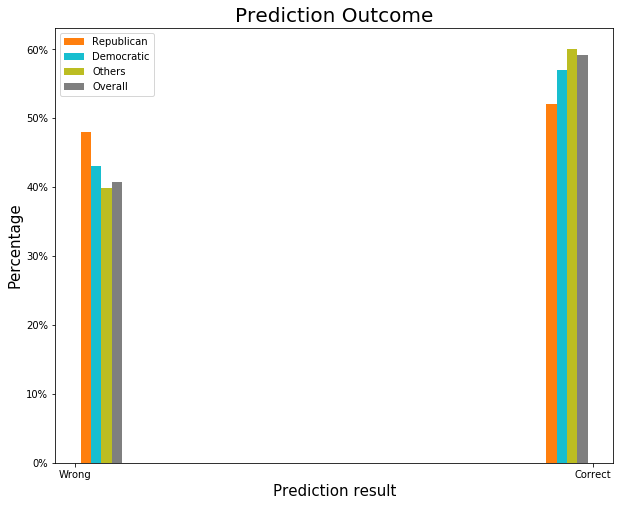

In [56]:

w1 = np.ones(len(rep_df.accurate))/len(rep_df.accurate)
w2 = np.ones(len(dem_df.accurate))/len(dem_df.accurate)
w3 = np.ones(len(oth_df.accurate))/len(oth_df.accurate)
w4 = np.ones(len(election_df.accurate))/len(election_df.accurate)

fig_4 = plt.figure(figsize = (10, 8))
plt.hist([rep_df['accurate'].astype(int), dem_df.accurate.astype(int), oth_df.accurate.astype(int), election_df.accurate.astype(int)], 
        weights = [w1,w2,w3,w4], color = ['tab:orange', 'tab:cyan', 'tab:olive', 'tab:grey'], label = ['Republican', 'Democratic', 'Others', 'Overall']);
plt.xticks([0, 1], labels = ['Wrong', 'Correct'])
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.title('Prediction Outcome', fontsize = 20)
plt.xlabel('Prediction result', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.legend(loc = 'best');
fig_4.show()

From our results, I think NLP analytics based on tweets can be helpful for political party leaders during election campaigns. One possible way of utilizing it is to look at the location of each tweets as well. For example, they can look at the sentiment distribution of major swing states (Florida, Texas etc.), and pay more attention to the states whose tweets sentiment is about 50% positive towards their political party. Further, party leaders can use NLP to filter out the negative tweets towards their party and look at why they are negative, so that campaign makers will be able to know where to improve. On the other hand, they can use NLP to filter out the positive tweets towards the opposing political party and look at why the opponent is so well-liked, so they can improve their own campaign accordingly.

Though some parties might have a lower accuracy than the otehrs, our model is rather accurate in predicting the sentiments of election tweets. Some possible ways to improve the prediction accuracy are: 
* adjusting the number of features so that more words are included in the feature space;
* try prepare the feature space with other methods such as word embedding;
* include tweets from the previous presidential election in the training set, so that more relavent words can be implemented as features;
* update training set (sentiment_analysis) consistently so that new "popular" words such as COVID19 and racial can be mentioned more often.

### 3.3 Negative reasons 

In this section, I will train models to predict the negative reasons of 2020 US election tweets. In the original dataframe, each negative tweet is assigned with a negative reason. There are five different negative reasons in this dataset.

First, I will look at what are the most commonly used words in the nagative tweets and determine the feature space accordingly. As we can see, there are in total 7571 useful words being used in the nagative tweets, that is way bigger than our sample size. Thus, I will only select the most used 100 words are our features to prevent overfitting. 

In [57]:
## Negative reasons of US election tweets 

neg_df_us = election_df[election_df.sentiment == 0]
neg_words_us = ' '.join(twt for twt in election_df.text)

In [78]:
elec_fdist = FreqDist(word for word in word_tokenize(neg_words_us))
print('Length of frequency dictionary is {}'.format(len(elec_fdist)))
most_freq_us = heapq.nlargest(100, elec_fdist, key=elec_fdist.get)  ## most frequently mentioned words, will be our feature space 

Length of frequency dictionary is 7970


Then, I will prepare the feature space using TF-IDF. There isn't any particular reason for me to choose this technique over the others, I just want to see how well it performs. The independed variable is the 100 words we jus selected, whose values are calculated using TF-IDF, and targe variable is the negative reason.

In [79]:
## now prepare feature space using TF-IDF

vectorizer3 = TfidfVectorizer(vocabulary=most_freq_us)
vectors3 = vectorizer3.fit_transform(neg_df_us.text)

dense3 = vectors3.todense()
denselist3 = dense3.tolist()
tfidf_us_df_neg = pd.DataFrame(denselist3, columns=most_freq_us)
tfidf_us_df_neg['y'] = neg_df_us['negative_reason'].values
tfidf_us_df_neg.head()

,trump,covid,bidenharris2020,vote,joebiden,realdonaldtrump,amp,biden,will,people,...,live,help,bad,moscowmitch,wait,hard,florida,texas,early,y
0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid19
1,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,others
2,0.0,0.0,0.0,0.0,0.0,0.0,0.680177,0.733048,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,covid19
3,0.0,0.0,0.0,0.0,0.0,0.0,0.458742,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,discrimination
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,discrimination


In [80]:
train_x_neg, test_x_neg, train_y_neg, test_y_neg = train_test_split(tfidf_us_df_neg.drop('y', axis = 1), tfidf_us_df_neg.y, test_size = 0.3, random_state = 24)

I will train a number of different different models on this dataset. The first one is logistic regression. I will tune my model using grid search. Since the sample size is much smaller than the sentiment analysis dataset, I decided to variate a couple more hyperparameters.

In [81]:
## model tunning for logistic regression

logi_us = LogisticRegression()
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0], 'penalty':['l1', 'l2'], 'fit_intercept':[True, False], 'dual':[True, False]}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(logi_us, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_neg, train_y_neg)
end_time = time.time()
print('It took time {} to complete grid search for logistic regression model'.format(end_time - start_time))

logi_us = grid_obj.best_estimator_ 

train_acc = accuracy_score(train_y_neg, logi_us.predict(train_x_neg))
test_acc = accuracy_score(test_y_neg, logi_us.predict(test_x_neg))
print('Best logistic regression model got training accuracy: {};\nTesting accuracy: {}'.format(round(train_acc, 4), round(test_acc, 4)))

It took time 1.067972183227539 to complete grid search for logistic regression model
Best logistic regression model got training accuracy: 0.3382;
Testing accuracy: 0.2789


The second model I will train is SVC model. Given the small sample size, it should not take too long to train a regular support vector classification model. Thus I will simply use the regular `SVC` model over the linear one.

In [82]:
## Model tunning for SVM
svm_us = svm.SVC()
parameters = {'C':[0.1, 0.5, 1.0, 2.0, 5.0], 'shrinking':[True, False], 'decision_function_shape':['ovo', 'ovr']}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(svm_us, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_neg, train_y_neg)
end_time = time.time()
print('It took time {} to complete grid search for SVM model'.format(end_time - start_time))

svm_us = grid_obj.best_estimator_ 

train_acc = accuracy_score(train_y_neg, svm_us.predict(train_x_neg))
test_acc = accuracy_score(test_y_neg, svm_us.predict(test_x_neg))
print('Best SVM model got training accuracy: {};\nTesting accuracy: {}'.format(round(train_acc, 4), round(test_acc, 4)))

It took time 10.624715089797974 to complete grid search for SVM model
Best SVM model got training accuracy: 0.3824;
Testing accuracy: 0.3079


Next, I trained a KNN model. The obvious hyperparameter to change is the number of neighbours. From the result, however, the KNN model does seem to be a little overfitting because the testing accuracy is a lot lower than the training accuracy. This is probably due to the hyperparameter "`leaf_size`", larger leaf size will lead to smaller training errors, which has is likely to cause overfitting.

In [83]:
## Model tunning for K-NN
knn_us = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 5, 8, 10], 'p':[1, 2, 10], 'leaf_size':[30, 50, 100, 300]}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(knn_us, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_neg, train_y_neg)
end_time = time.time()
print('It took time {} to complete grid search for KNN model'.format(end_time - start_time))

knn_us = grid_obj.best_estimator_ 

train_acc = accuracy_score(train_y_neg, knn_us.predict(train_x_neg))
test_acc = accuracy_score(test_y_neg, knn_us.predict(test_x_neg))
print('Best KNN model got training accuracy: {};\nTesting accuracy: {}'.format(round(train_acc, 4), round(test_acc, 4)))

It took time 9.640101194381714 to complete grid search for KNN model
Best KNN model got training accuracy: 0.4355;
Testing accuracy: 0.2421


Lastly, I trained the multinomial naive bayes model. As discussed before, though the features are not strictly multinomial distributed, it is still okay for us to use multinomial NB here for classification. 

In [84]:
## Model tunning for multinomial naive bayes 

nb_us = MultinomialNB()
parameters = {'alpha':[0.0, 1.0, 3.0, 5.0], 'fit_prior':[True, False]}

acc_scorer = make_scorer(accuracy_score)

start_time = time.time()
grid_obj = GridSearchCV(nb_us, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train_x_neg, train_y_neg)
end_time = time.time()
print('It took time {} to complete grid search for KNN model'.format(end_time - start_time))

nb_us = grid_obj.best_estimator_ 

train_acc = accuracy_score(train_y_neg, nb_us.predict(train_x_neg))
test_acc = accuracy_score(test_y_neg, nb_us.predict(test_x_neg))
print('Best multinomial naive Bayes model got training accuracy: {};\nTesting accuracy: {}'.format(round(train_acc, 4), round(test_acc, 4)))

It took time 0.13939619064331055 to complete grid search for KNN model
Best multinomial naive Bayes model got training accuracy: 0.3812;
Testing accuracy: 0.2974


In [85]:
train_acc1 = accuracy_score(train_y_neg, logi_us.predict(train_x_neg))
test_acc1 = accuracy_score(test_y_neg, logi_us.predict(test_x_neg))
train_acc2 = accuracy_score(train_y_neg, svm_us.predict(train_x_neg))
test_acc2 = accuracy_score(test_y_neg, svm_us.predict(test_x_neg))
train_acc3 = accuracy_score(train_y_neg, knn_us.predict(train_x_neg))
test_acc3 = accuracy_score(test_y_neg, knn_us.predict(test_x_neg))
train_acc4 = accuracy_score(train_y_neg, nb_us.predict(train_x_neg))
test_acc4 = accuracy_score(test_y_neg, nb_us.predict(test_x_neg))


tb2 = PrettyTable(title = 'Prediction accuracy on negative reasons')

tb2.field_names = [' ', 'Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']

tb2.add_row(['Training accuracy', train_acc1, train_acc2, train_acc3, train_acc4])
tb2.add_row(['Testing accuracy', test_acc1, test_acc2, test_acc3, test_acc4])

print(tb2)

+-----------------------------------------------------------------------------------------------------------+
|                                  Prediction accuracy on negative reasons                                  |
+-------------------+---------------------+---------------------+---------------------+---------------------+
|                   | Logistic Regression |         SVM         |         KNN         |     Naive Bayes     |
+-------------------+---------------------+---------------------+---------------------+---------------------+
| Training accuracy |  0.3382352941176471 | 0.38235294117647056 | 0.43552036199095023 | 0.38122171945701355 |
|  Testing accuracy |  0.2789473684210526 |  0.3078947368421053 | 0.24210526315789474 | 0.29736842105263156 |
+-------------------+---------------------+---------------------+---------------------+---------------------+


All four models had testing accuracy around 30%, which suggests none of them is highly accurate in term of predicting negative reasons of a tweet. The most accurate one seems to be the support vector machine, whose testing accuracy is still no larger than 33%. There are a number of reasons that could lead to the low testing accuracy of our models:
* multiclass classification models are more complex than two-class classification models, thus we need a lot more samples to train our models;
* in fact, the low training accuracy suggests that all our models were under-trained, more samples are needed; 
* in the US election dataset, about 1/3 of the negative tweets are reasoned as COVID19, this ratio is very close to our prediction accuracy. This means that our model will simply "guess" the reason to be COVID19 if it is not very sure what the real reason is.

The last point is a little hard to understand, but let's look at the predictions that are made by our model. Our prediction is very different from the real negative reasons because in most cases, if the features do not suggest "strong enough" reasons, our model will predict "covid19" as the reason. This, again, suggests that our model is under-trained. Simply increase the number of training samples will increase our model's performance. 

Back to the research question posted earlier, from our result, we can tell that the public opinion towards the Democratic party is more positive than that towdars the Republican party. Supporters of the Republican party are not as vocal on social media compare to supporters of Democratic party. Trump is very disliked among netizens, partly because how he handles the pandemic. COVID-19 is the most concerned issue in America right now. 

In [86]:
## predicted reasons 
svm_us.predict(test_x_neg)

array(['covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'crime',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'crime', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'discrimination', 'covid19', 'covid19',
       'covid19', 'covid19', 'corruption', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'corruption', 'crime', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'cov

In [87]:
## real negative reasons
test_y_neg.values

array(['crime', 'covid19', 'corruption', 'covid19', 'covid19',
       'discrimination', 'others', 'discrimination', 'corruption',
       'covid19', 'covid19', 'discrimination', 'discrimination', 'others',
       'corruption', 'others', 'corruption', 'others', 'covid19',
       'covid19', 'crime', 'crime', 'crime', 'discrimination', 'others',
       'covid19', 'corruption', 'crime', 'discrimination', 'others',
       'corruption', 'crime', 'crime', 'crime', 'others', 'others',
       'covid19', 'crime', 'crime', 'covid19', 'covid19', 'crime',
       'crime', 'others', 'discrimination', 'crime', 'crime', 'covid19',
       'others', 'discrimination', 'covid19', 'others', 'crime',
       'covid19', 'others', 'covid19', 'covid19', 'discrimination',
       'crime', 'covid19', 'corruption', 'covid19', 'corruption', 'crime',
       'covid19', 'discrimination', 'corruption', 'crime', 'covid19',
       'discrimination', 'others', 'corruption', 'others',
       'discrimination', 'crime', 'discrim